# Project Goals:
- Create documented files to clean and prepare Zillow dataset for processing by regression ML algorithms.
- Use ML algorithms to create a model that best predicts tax value of properties on both in and out-of-sample data.
- Evaluate each iteration of my models while changing parameters and features to find the best model in terms of RMSE and R^2 score.
- Document processes, findings, and takeaways in a draft Jupyter Notebook
- Present on my final Jupyter Notebook in a canva slide deck, giving a high-level overview of the process used to create the model of best fit as well as basic evaluation metrics of the model.

## Initial Hypotheses:

> $H_{i}$: Bedroom count and bathroom count are the main drivers of tax_value

## Key Findings/Takeaways:
> My best preforming Linear Regression model had an r^2 value of 0.33 and an RMSE of $\$$270,211 on my out-of-sample test dataset 

> Los Angeles had the highest share of properties as well as the highest tax rate. OLS model outperformed other models with a very close second being my Lars + Lasso (R^2 Test:  0.329, RMSE Test: $\$$270,206). Features most correlated with property value were area and bathroom count and bedroom count. 


# Imports

In [1]:
import acquire as ac
import prepare as pr
import explore as ex
import evaluate as ev
import stat_tests as st
import model as md


import random
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures
import sklearn.preprocessing
import scipy.stats as stats
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
from datetime import date

import warnings
warnings.filterwarnings("ignore")

# Acquire

In [2]:
raw = ac.acquire_zillow()
raw.shape

(28225, 8)

In [3]:
raw.head()

,bedrooms,bathrooms,area,tax_value,year_built,taxamount,fips,sale_date
0,3.0,2.0,1316.0,205123.0,1923.0,2627.48,6037.0,2017-07-21
1,3.0,2.0,1458.0,136104.0,1970.0,2319.90,6037.0,2017-06-23
2,2.0,1.0,1421.0,35606.0,1911.0,543.69,6037.0,2017-06-30
3,4.0,3.0,2541.0,880456.0,2003.0,9819.72,6059.0,2017-06-01
4,3.0,2.0,1491.0,107110.0,1955.0,1399.27,6037.0,2017-08-23


In [4]:
ac.summarize_df(raw)

This dataframe has 28225 rows and 8 columns.
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
****Info****
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28225 entries, 0 to 28224
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   bedrooms    28225 non-null  float64
 1   bathrooms   28225 non-null  float64
 2   area        28152 non-null  float64
 3   tax_value   28224 non-null  float64
 4   year_built  28129 non-null  float64
 5   taxamount   28224 non-null  float64
 6   fips        28225 non-null  float64
 7   sale_date   28225 non-null  object 
dtypes: float64(7), object(1)
memory usage: 1.7+ MB
None
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
****Null Counts****
bedrooms: 0
bathrooms: 0
area: 73
tax_value: 1
year_built: 96
taxamount: 1
fips: 0
sale_date: 0
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
****Value Counts****
3.0     12576
4.0      8294
2.0      4375
5.0      2143
6.0       340
1.0       314
0.0       113
7.0        50
8.0         8
9.0        

# Prepare

In [5]:
zillow = pr.prepare_zillow()
zillow.shape

(26884, 10)

In [6]:
f'Dropped {raw.shape[0] - zillow.shape[0]} rows from nulls and outliers'

'Dropped 1341 rows from nulls and outliers'

In [7]:
zillow.head()

,bedrooms,bathrooms,area,tax_value,year_built,taxamount,fips,county,month_sold,tax_rate
0,3.0,2.0,1316.0,205123.0,1923.0,2627.48,6037.0,Los Angeles,7,0.012809
1,3.0,2.0,1458.0,136104.0,1970.0,2319.90,6037.0,Los Angeles,6,0.017045
2,2.0,1.0,1421.0,35606.0,1911.0,543.69,6037.0,Los Angeles,6,0.015270
3,4.0,3.0,2541.0,880456.0,2003.0,9819.72,6059.0,Orange,6,0.011153
4,3.0,2.0,1491.0,107110.0,1955.0,1399.27,6037.0,Los Angeles,8,0.013064


In [13]:
taxes = pd.DataFrame({'county':zillow.county,'tax_rate':zillow.tax_rate * 100})
taxes.head()

,county,tax_rate
0,Los Angeles,1.280929
1,Los Angeles,1.704505
2,Los Angeles,1.526962
3,Orange,1.115299
4,Los Angeles,1.306386


In [15]:
round(taxes.groupby('county').tax_rate.mean(), 2)

county
Los Angeles    1.42
Orange         1.21
Ventura        1.18
Name: tax_rate, dtype: float64

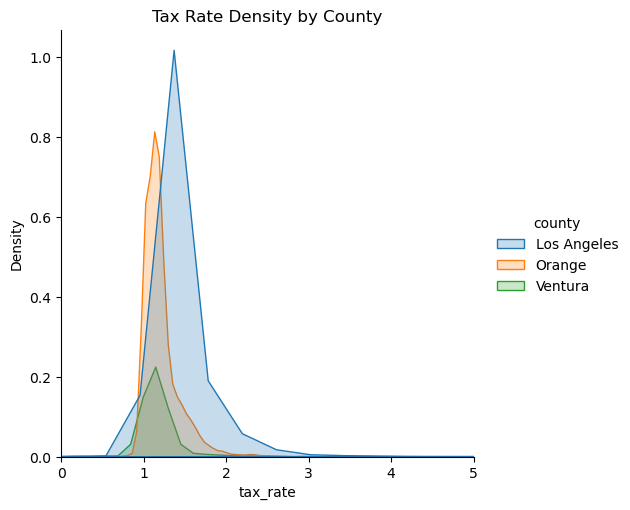

In [18]:
sns.displot(taxes, x="tax_rate", hue="county", kind='kde',fill=True)
plt.xlim([0, 5])
plt.title('Tax Rate Density by County')
plt.show()

In [19]:
# Basic summary of prepped df
ac.summarize_df(zillow)

This dataframe has 26884 rows and 10 columns.
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
****Info****
<class 'pandas.core.frame.DataFrame'>
Int64Index: 26884 entries, 0 to 28224
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   bedrooms    26884 non-null  float64
 1   bathrooms   26884 non-null  float64
 2   area        26884 non-null  float64
 3   tax_value   26884 non-null  float64
 4   year_built  26884 non-null  object 
 5   taxamount   26884 non-null  float64
 6   fips        26884 non-null  object 
 7   county      26884 non-null  object 
 8   month_sold  26884 non-null  int64  
 9   tax_rate    26884 non-null  float64
dtypes: float64(6), int64(1), object(3)
memory usage: 2.3+ MB
None
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
****Null Counts****
bedrooms: 0
bathrooms: 0
area: 0
tax_value: 0
year_built: 0
taxamount: 0
fips: 0
county: 0
month_sold: 0
tax_rate: 0
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
****Value Counts****
3.0    12328
4.0     7

In [20]:
# splitting data into X/y train, validate, and test datasets
X_train, X_validate, X_test, y_train, y_validate, y_test = pr.tvt_split()
X_train.shape, X_validate.shape, X_test.shape, y_train.shape[0], y_validate.shape[0], y_test.shape[0]

((15054, 4), (6453, 4), (5377, 4), 15054, 6453, 5377)

# Explore

In [21]:
explore_train, explore_validate, explore_test = pr.tvt_split(target = None)

In [22]:
explore_train.head()

,bedrooms,bathrooms,area,tax_value,month_sold
4406,6.0,3.0,3507.0,616142.0,5
6788,4.0,2.0,2110.0,87354.0,5
18633,3.0,3.0,3116.0,263921.0,7
182,6.0,3.0,2901.0,425115.0,5
24485,3.0,2.5,2828.0,1250000.0,8


In [23]:
X_train.head()

,bedrooms,bathrooms,area,month_sold
4406,6.0,3.0,3507.0,5
6788,4.0,2.0,2110.0,5
18633,3.0,3.0,3116.0,7
182,6.0,3.0,2901.0,5
24485,3.0,2.5,2828.0,8


Histograms for each feature


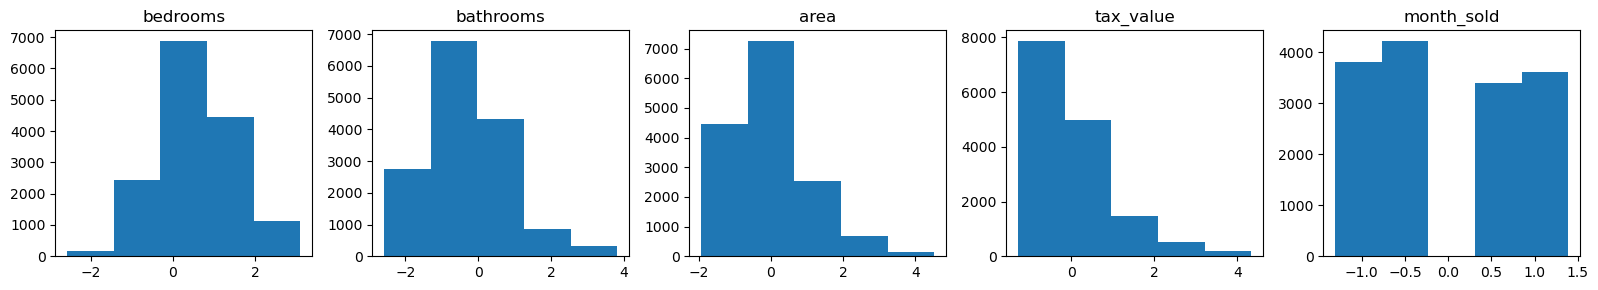

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Relplots for each cat/quant feature pairing


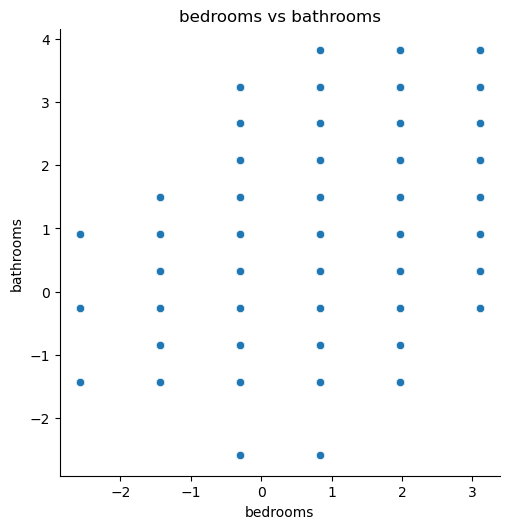

_____________________________________________


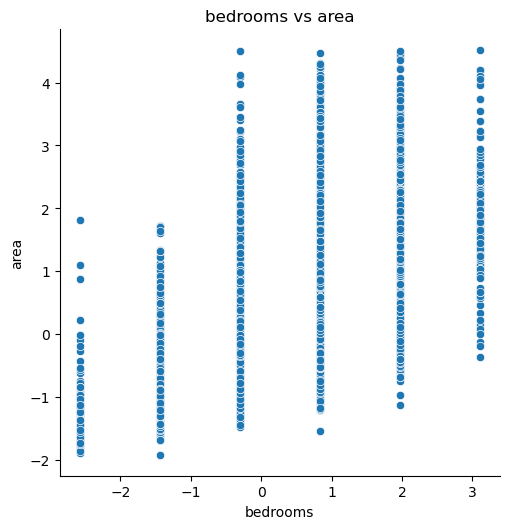

_____________________________________________


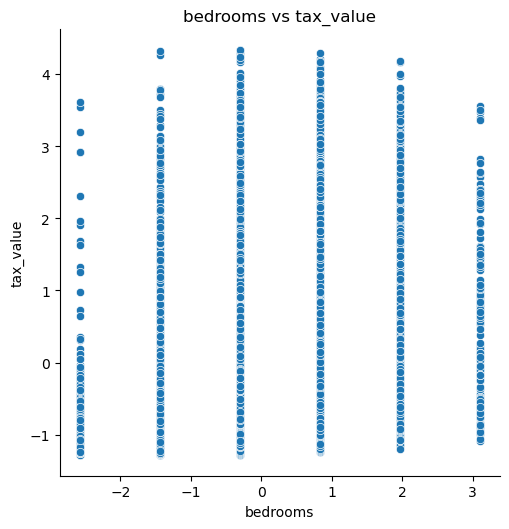

_____________________________________________


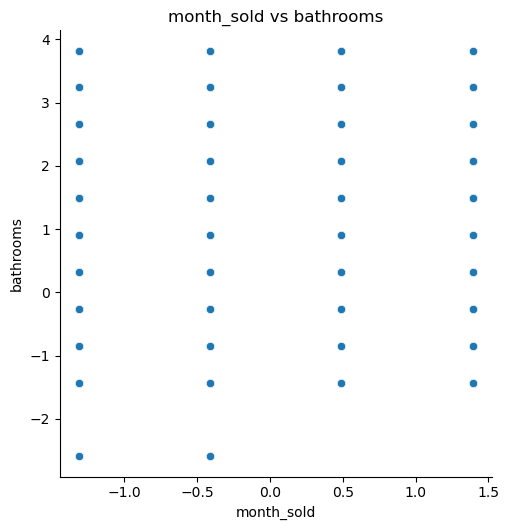

_____________________________________________


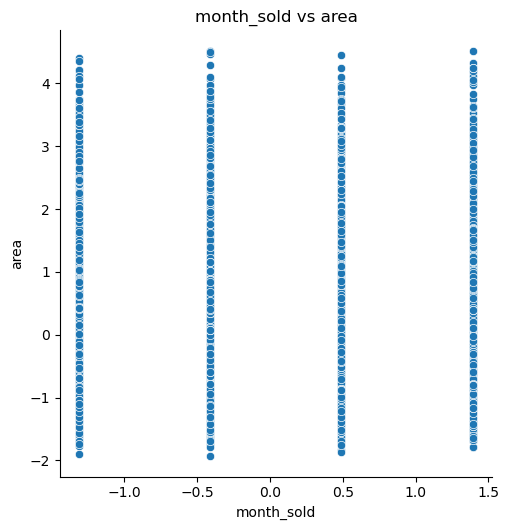

_____________________________________________


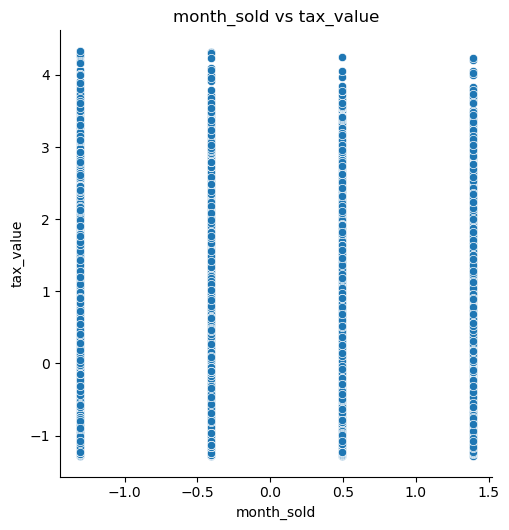

_____________________________________________


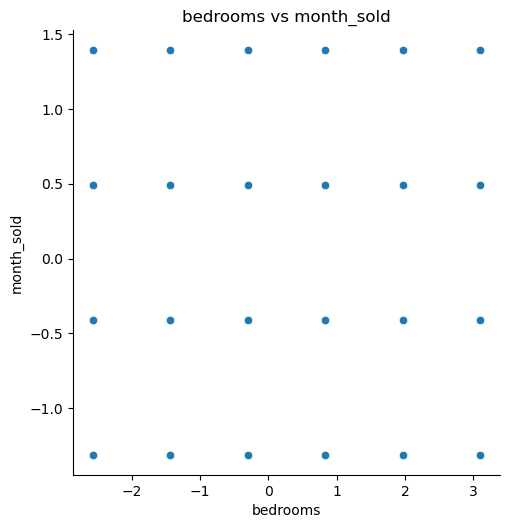

_____________________________________________


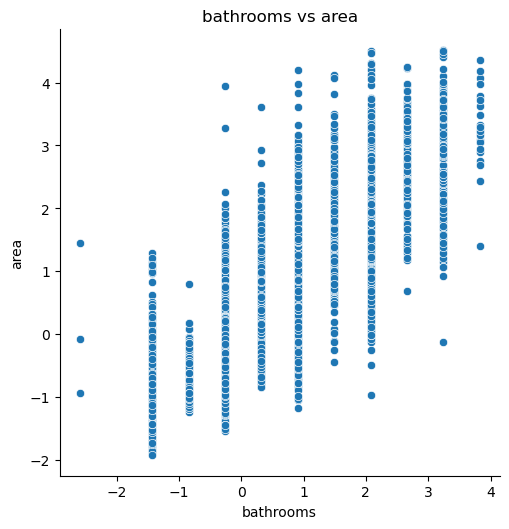

_____________________________________________


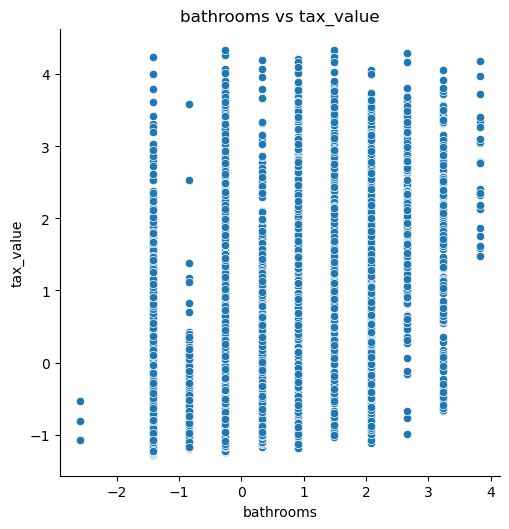

_____________________________________________


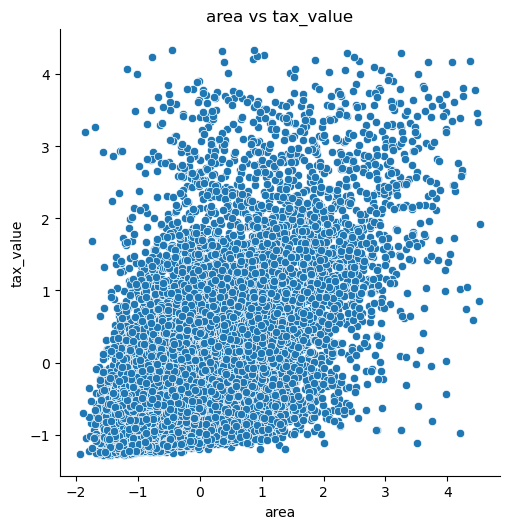

_____________________________________________
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Lmplots for each cat/quant feature pairing


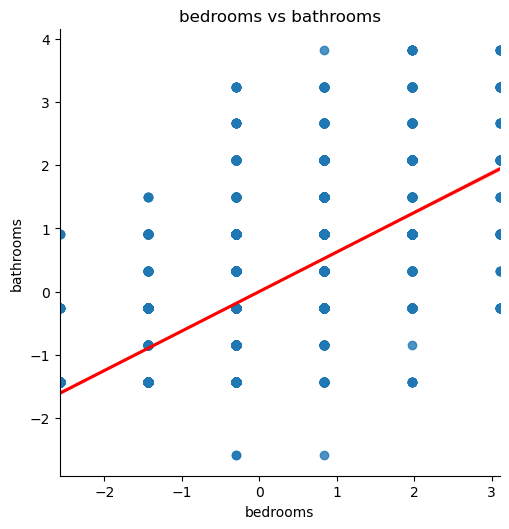

_____________________________________________


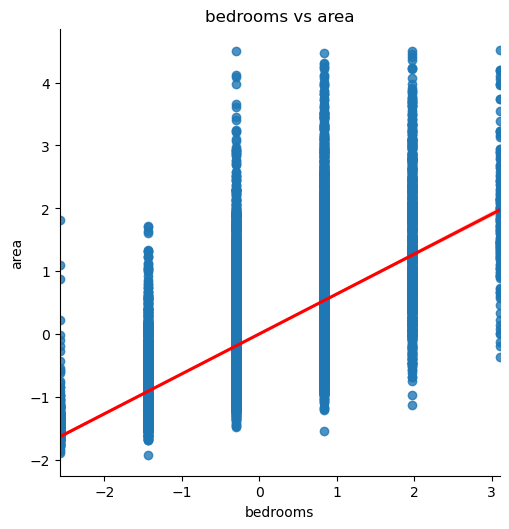

_____________________________________________


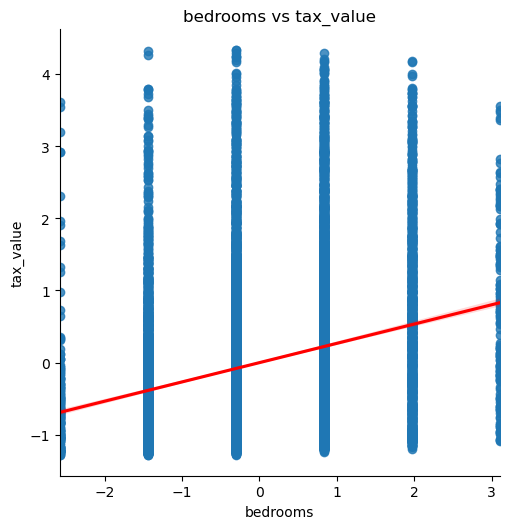

_____________________________________________


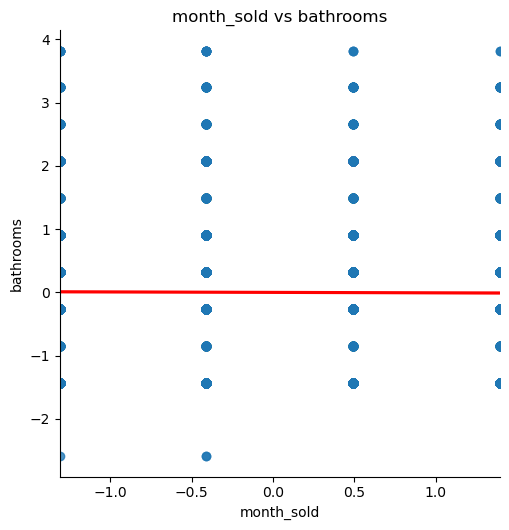

_____________________________________________


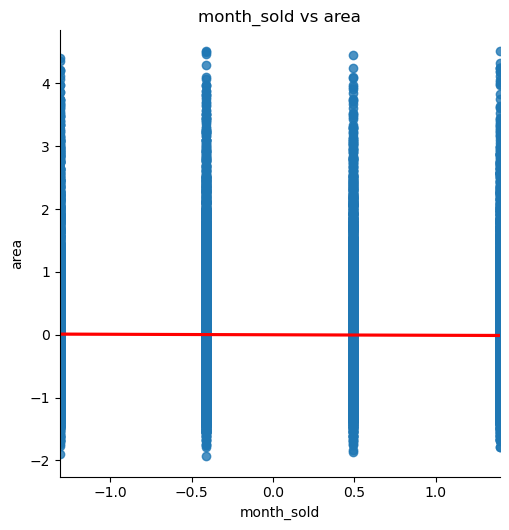

_____________________________________________


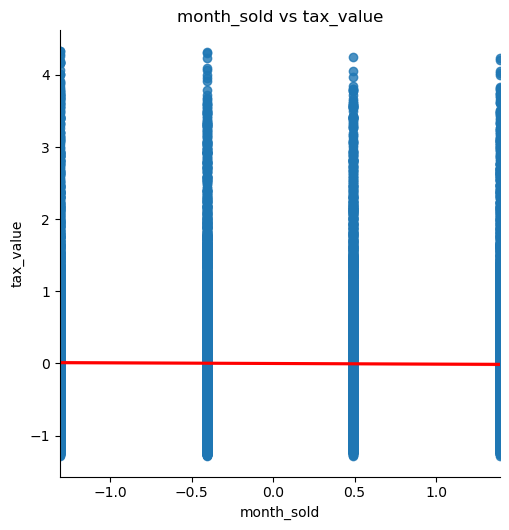

_____________________________________________


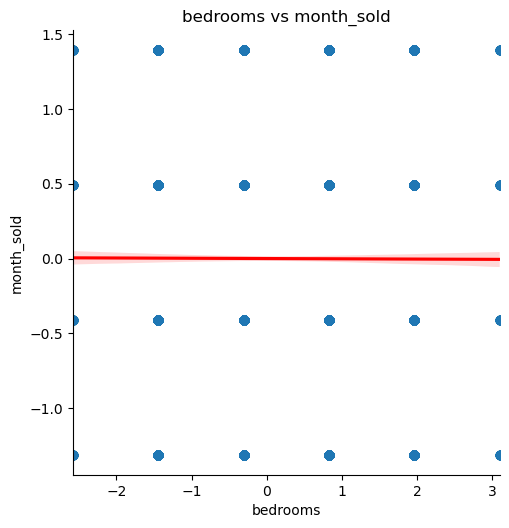

_____________________________________________


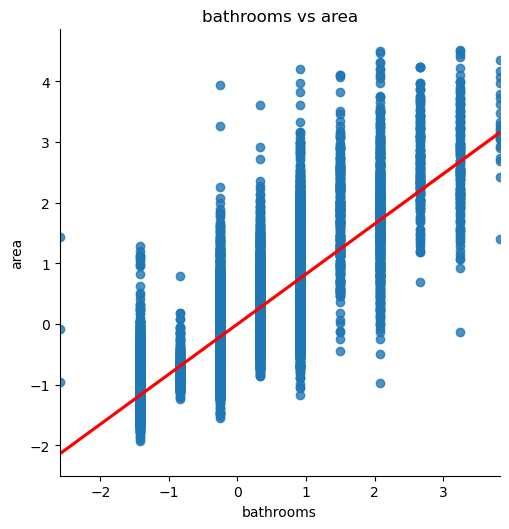

_____________________________________________


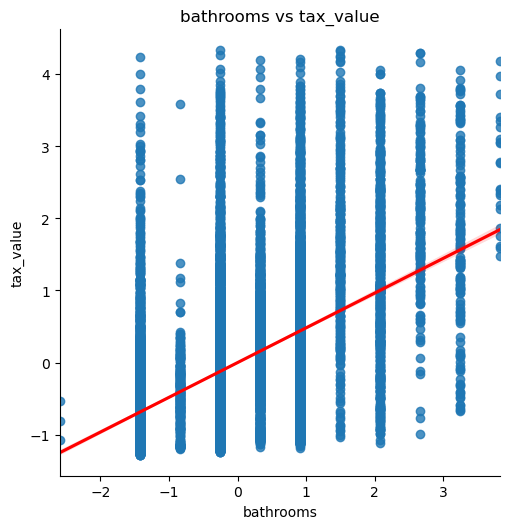

_____________________________________________


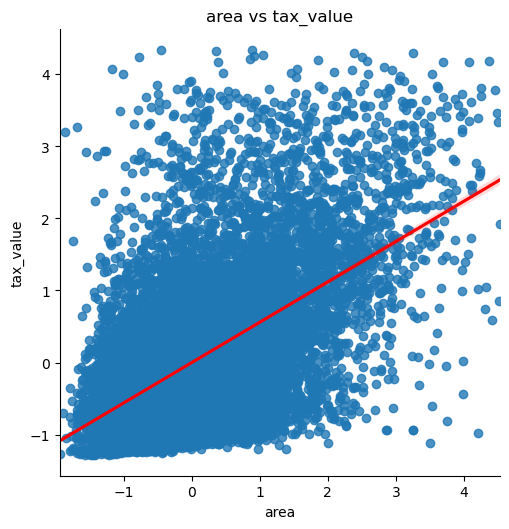

_____________________________________________
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Jointplots for each cat/quant feature pairing


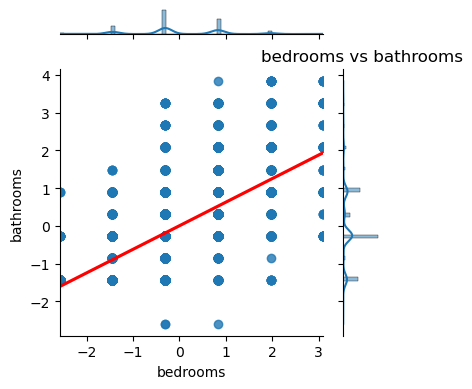

_____________________________________________


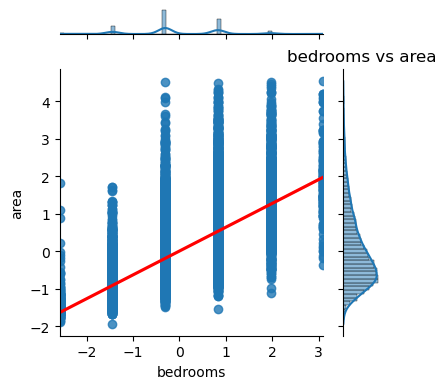

_____________________________________________


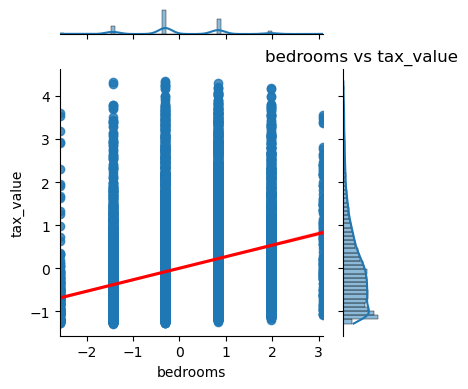

_____________________________________________


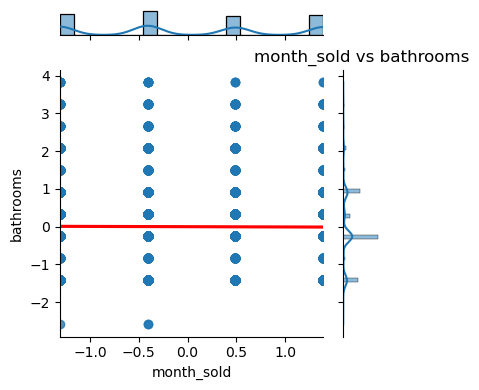

_____________________________________________


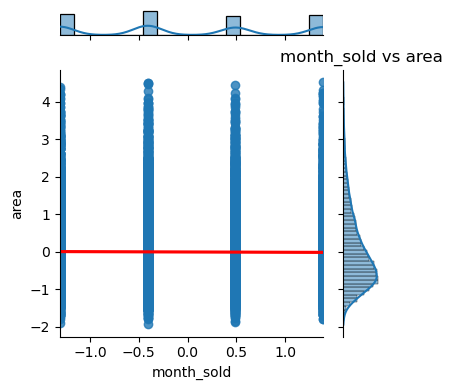

_____________________________________________


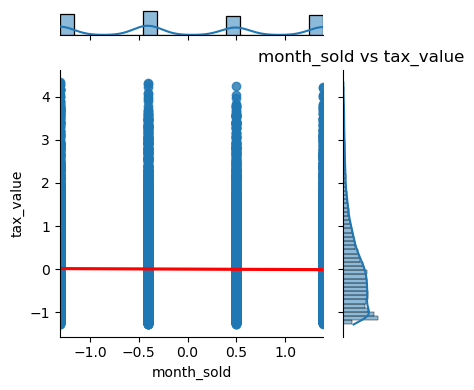

_____________________________________________


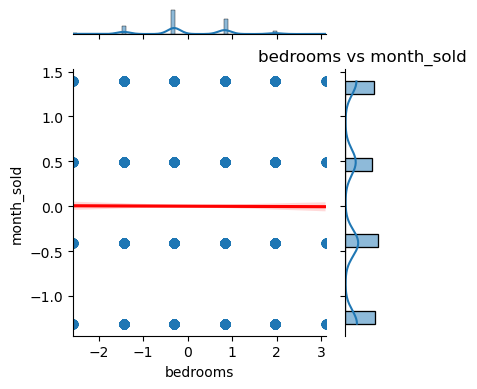

_____________________________________________


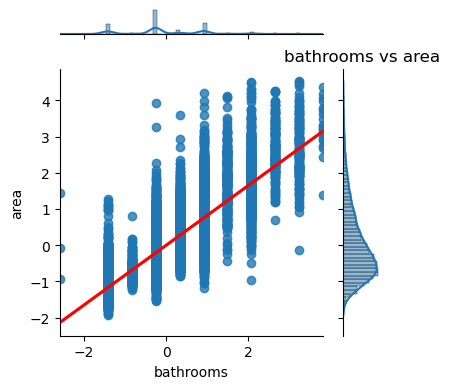

_____________________________________________


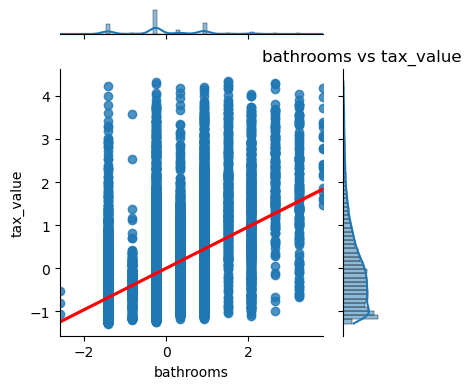

_____________________________________________


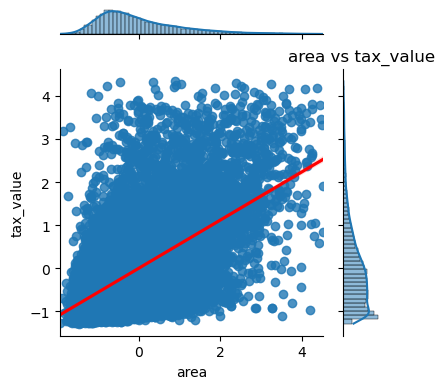

_____________________________________________
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Heatmaps for feature combos (len >= 3)


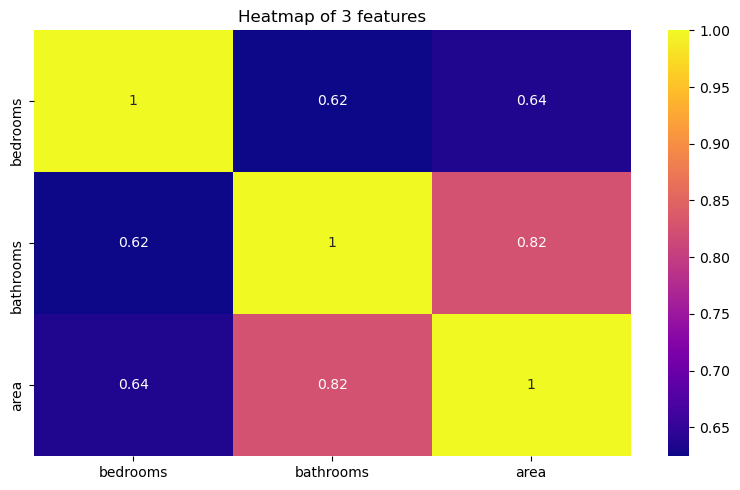

Heatmap features: ('bedrooms', 'bathrooms', 'area')
_____________________________________________


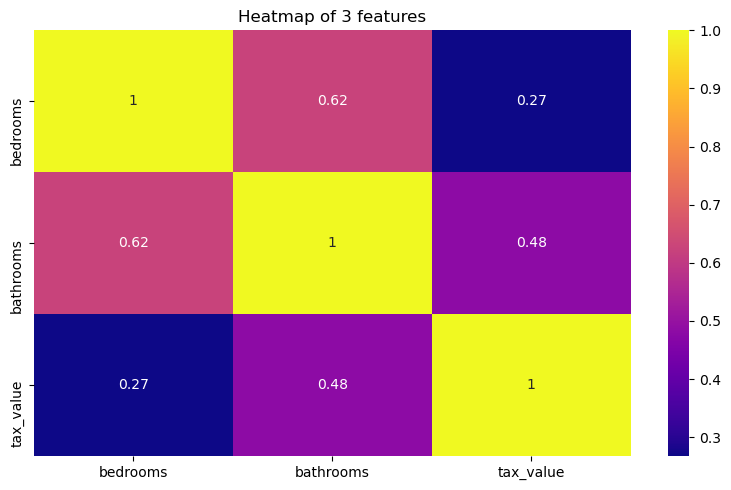

Heatmap features: ('bedrooms', 'bathrooms', 'tax_value')
_____________________________________________


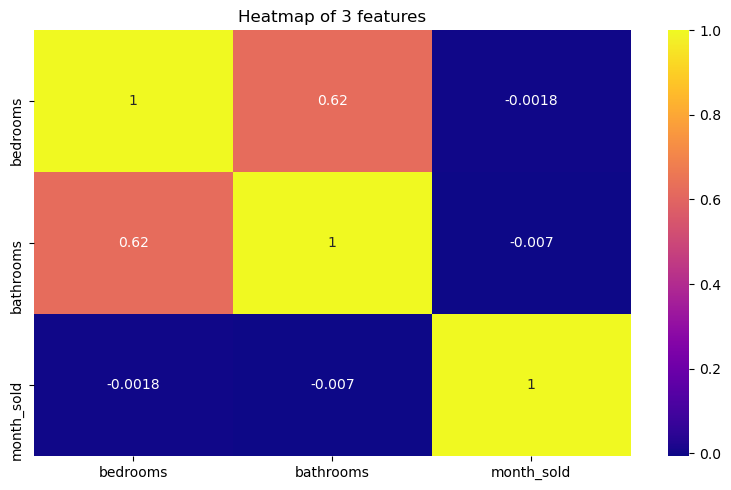

Heatmap features: ('bedrooms', 'bathrooms', 'month_sold')
_____________________________________________


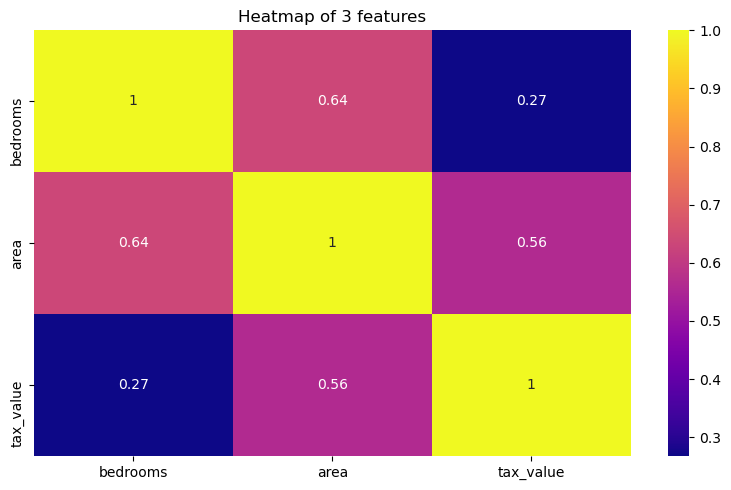

Heatmap features: ('bedrooms', 'area', 'tax_value')
_____________________________________________


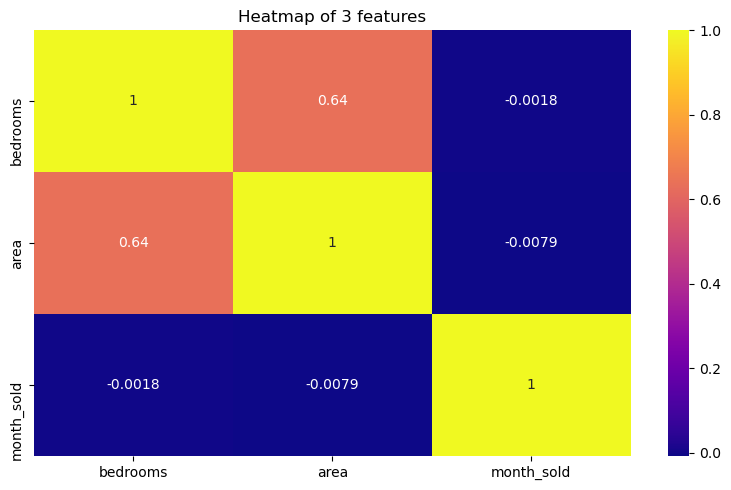

Heatmap features: ('bedrooms', 'area', 'month_sold')
_____________________________________________


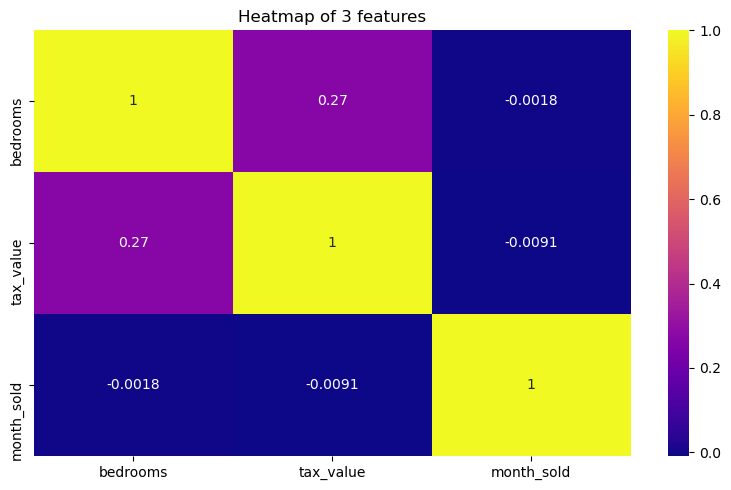

Heatmap features: ('bedrooms', 'tax_value', 'month_sold')
_____________________________________________


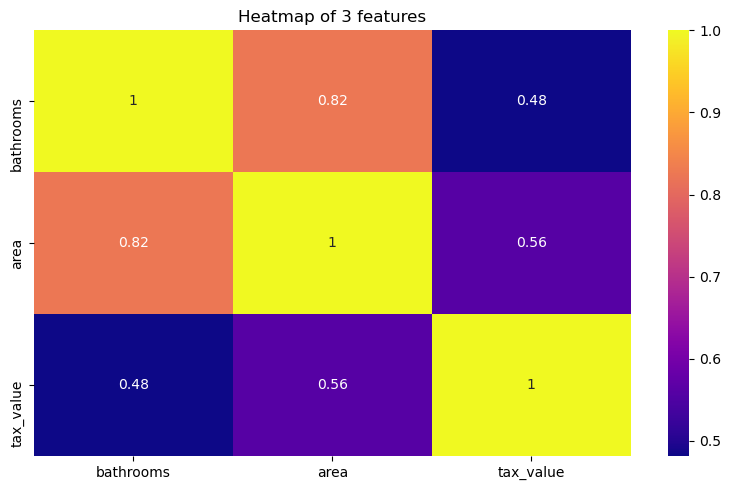

Heatmap features: ('bathrooms', 'area', 'tax_value')
_____________________________________________


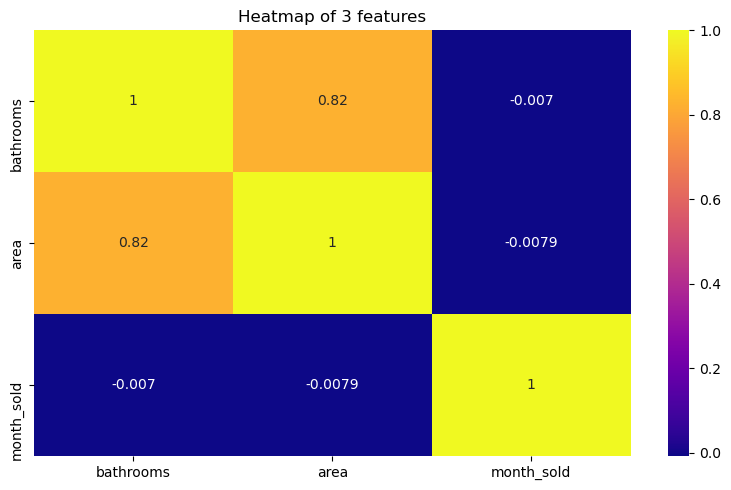

Heatmap features: ('bathrooms', 'area', 'month_sold')
_____________________________________________


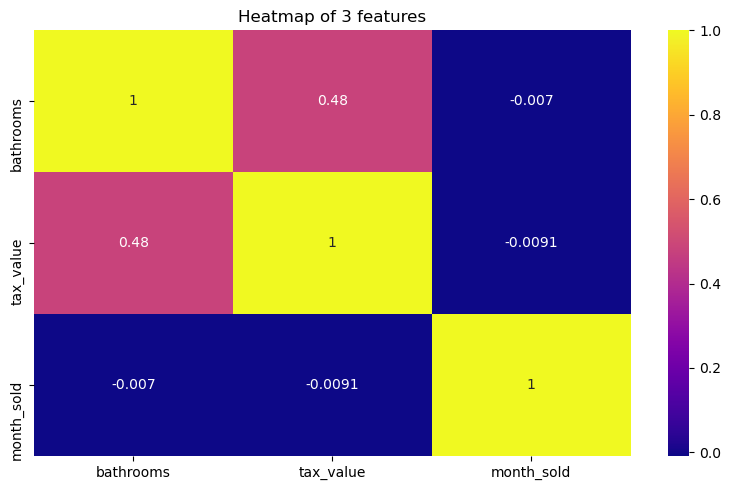

Heatmap features: ('bathrooms', 'tax_value', 'month_sold')
_____________________________________________


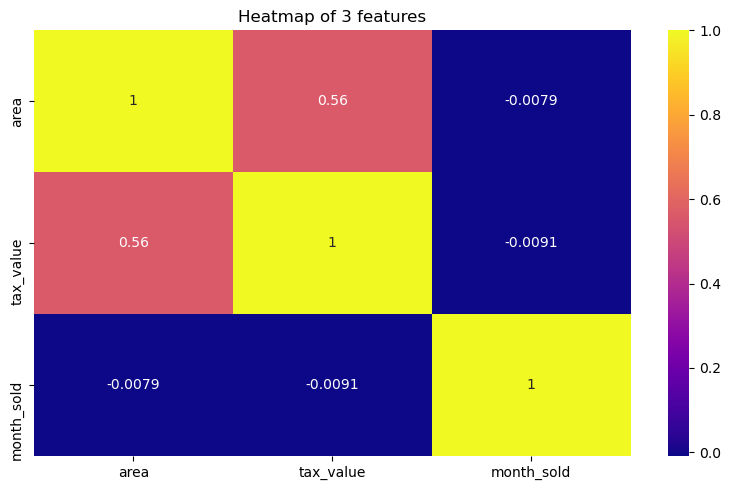

Heatmap features: ('area', 'tax_value', 'month_sold')
_____________________________________________


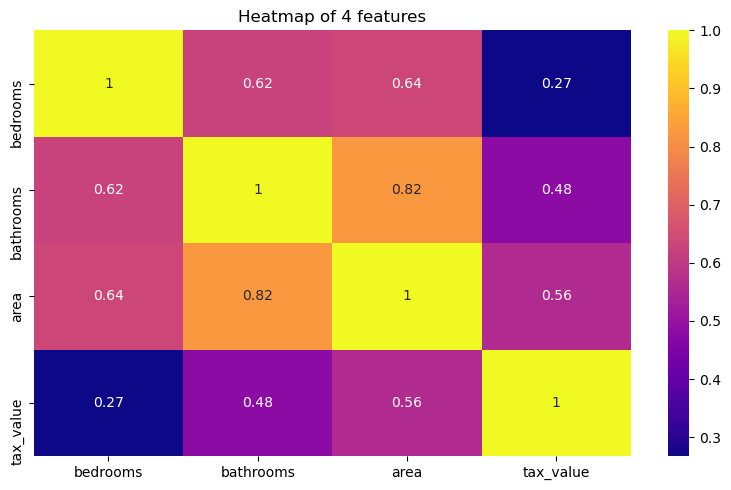

Heatmap features: ('bedrooms', 'bathrooms', 'area', 'tax_value')
_____________________________________________


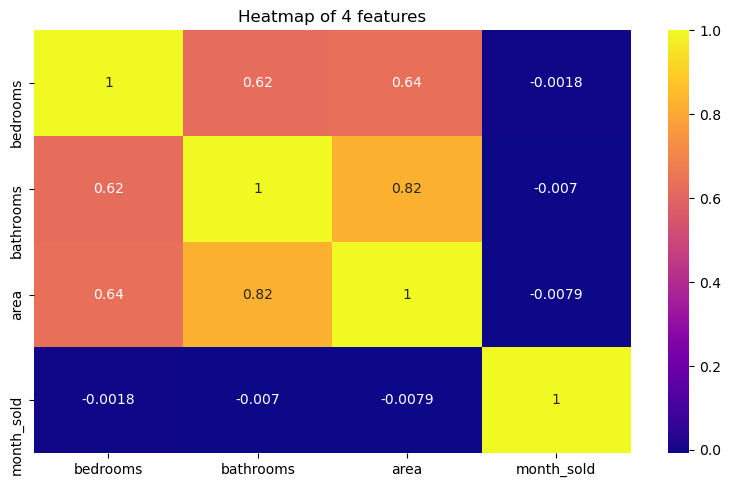

Heatmap features: ('bedrooms', 'bathrooms', 'area', 'month_sold')
_____________________________________________


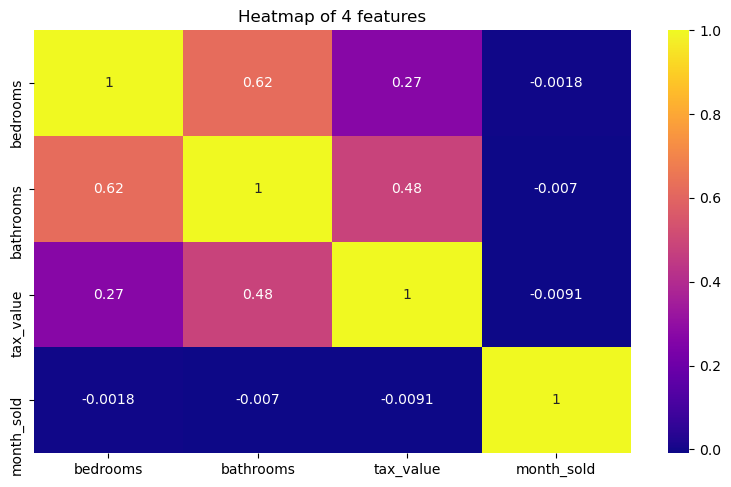

Heatmap features: ('bedrooms', 'bathrooms', 'tax_value', 'month_sold')
_____________________________________________


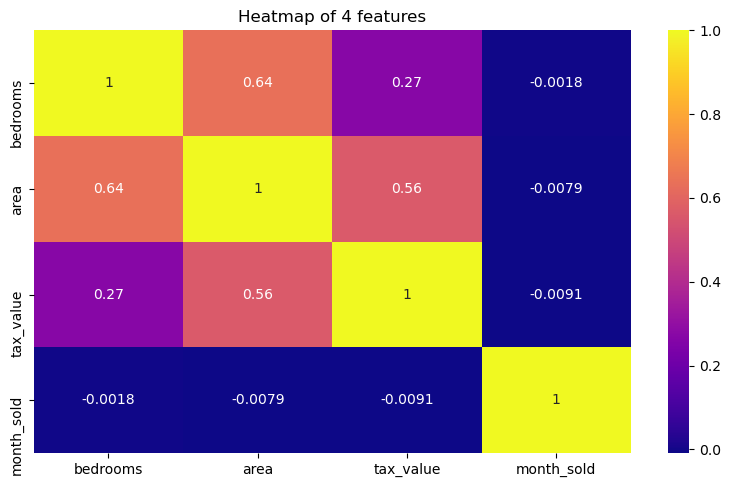

Heatmap features: ('bedrooms', 'area', 'tax_value', 'month_sold')
_____________________________________________


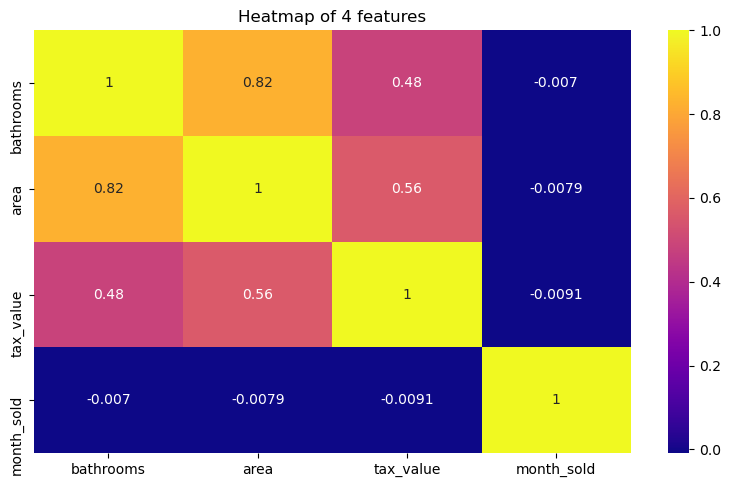

Heatmap features: ('bathrooms', 'area', 'tax_value', 'month_sold')
_____________________________________________


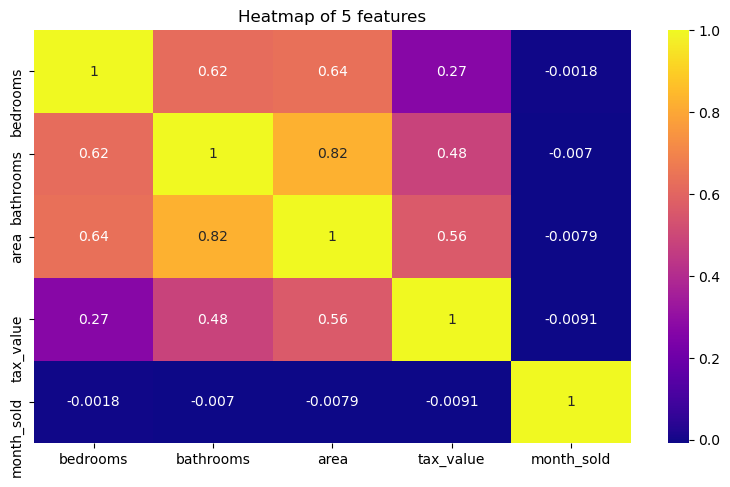

Heatmap features: ('bedrooms', 'bathrooms', 'area', 'tax_value', 'month_sold')
_____________________________________________
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Pairplot of quant vars and target


<Figure size 500x500 with 0 Axes>

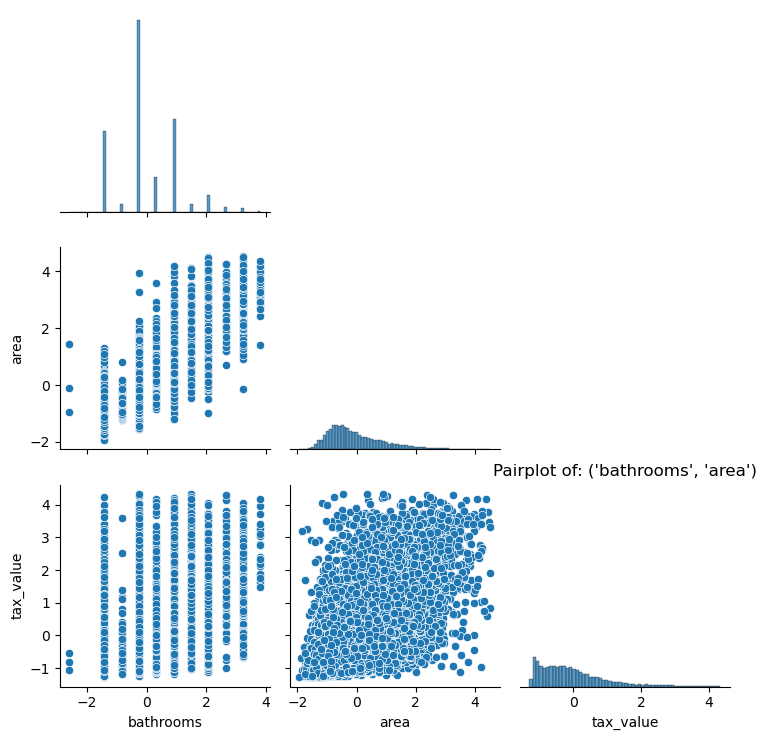

_____________________________________________


<Figure size 500x500 with 0 Axes>

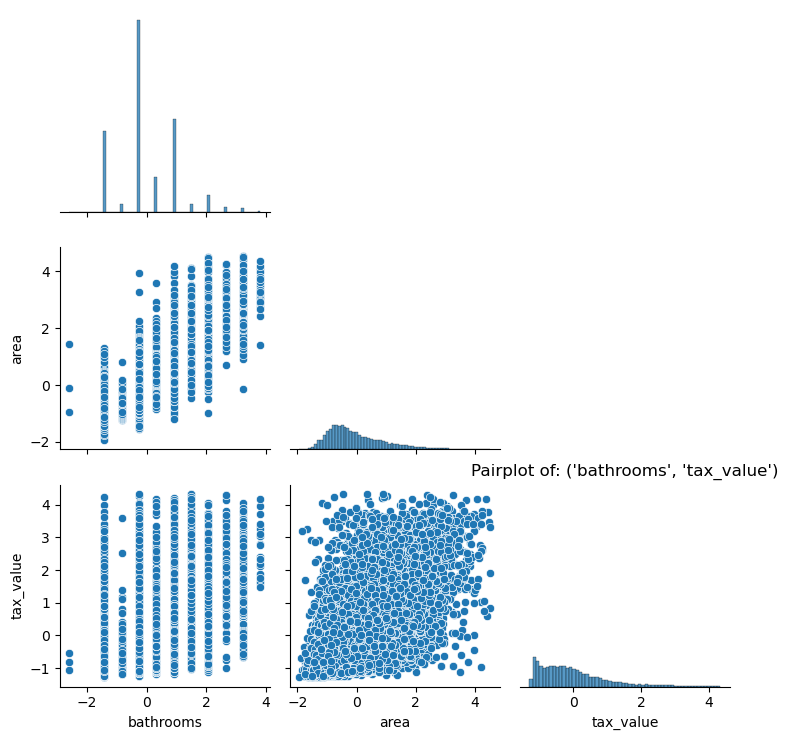

_____________________________________________


<Figure size 500x500 with 0 Axes>

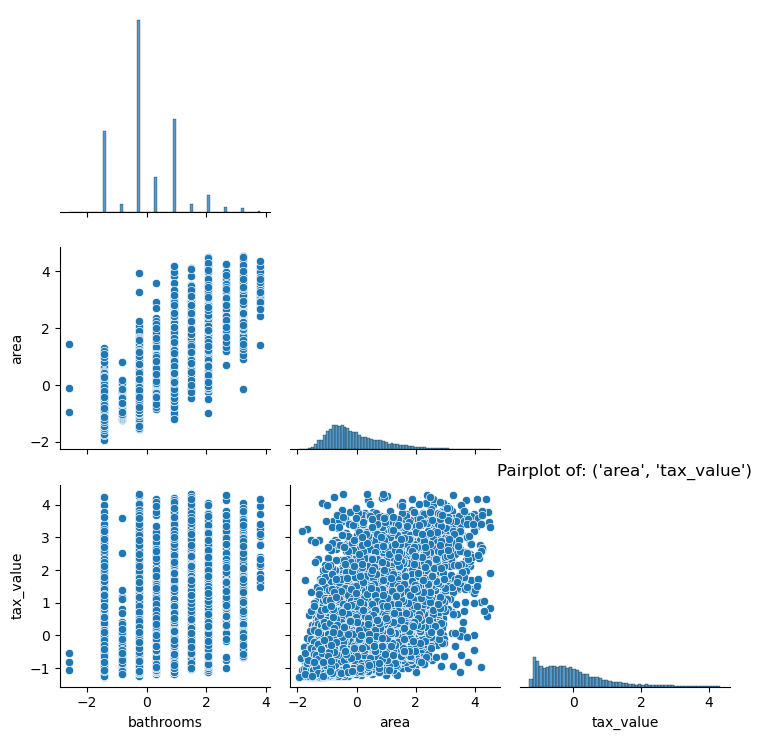

_____________________________________________


<Figure size 500x500 with 0 Axes>

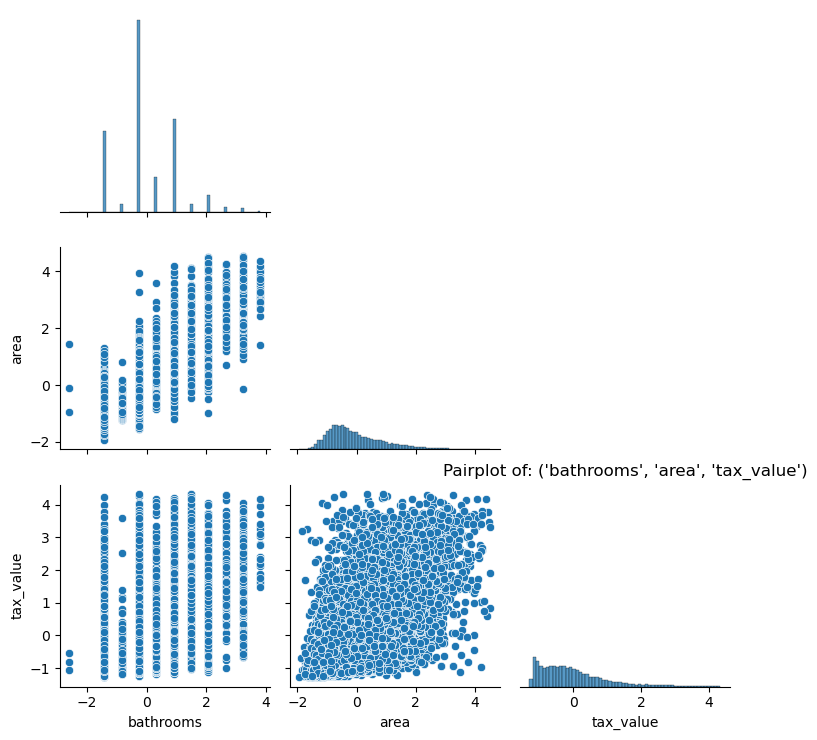

_____________________________________________


In [24]:
ex.plot_categorical_and_continuous_vars()

#### Takeaways:
- area and bedrooms highly correlated
- area and bathrooms also highly correlated
- bedrooms and bathrooms correlated
- tax_value most correlated with area and bathrooms

In [25]:
round(explore_train.bathrooms.mean(), 2)

2.22

In [26]:
round(explore_train.bedrooms.mean(), 2)

3.27

## Hypothesis Testing:
### Questions:
- $Q_{1}$: Are bedrooms and bathrooms correlated?
- $Q_{2}$: Do homes with 3+ bedrooms have higher tax_value than average homes?

In [27]:
alpha = .05

### Question 1: Are bedrooms and bathrooms correlated?
- $H_{0}$: Bedrooms and bathrooms are independent.
- $H_{a}$: Bedrooms and bathrooms are dependent.

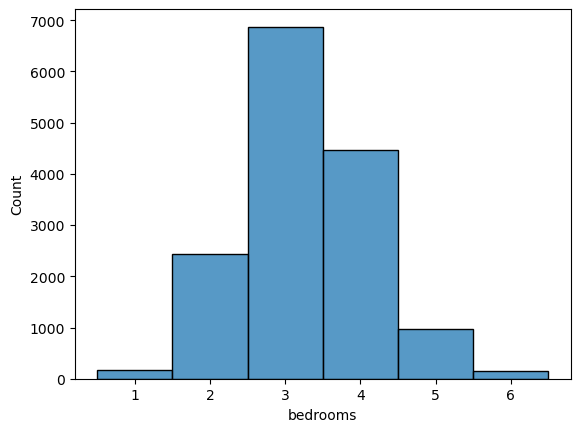

In [28]:
sns.histplot(data = explore_train['bedrooms'], discrete = True)
plt.show()

bathrooms 
_____________________

          chi2  p-value  degrees of freedom
0  9188.255267      0.0                  50

observed:
 bedrooms   1.0   2.0   3.0   4.0  5.0  6.0    All
bathrooms                                        
0.0          0     0     2     1    0    0      3
1.0        159  1487  1041    58    7    0   2752
1.5          0    67   149    42    1    0    259
2.0         13   757  3988  1643  103   15   6519
2.5          0    44   571   519   57    4   1195
3.0          3    74   954  1645  426   40   3142
3.5          0     4    59   164   50    6    283
4.0          0     0    88   267  167   42    564
4.5          0     0    11    75   75    6    167
5.0          0     0    10    46   69   23    148
5.5          0     0     0     1   13    8     22
All        175  2433  6873  4461  968  144  15054

expected:
             0            1            2            3           4          5
0    0.034874     0.484855     1.369669     0.889000    0.192906   0.028697
1 

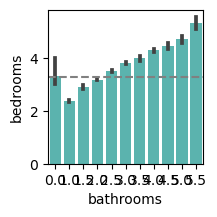


_____________________



In [29]:
ex.explore_bivariate_categorical(explore_train, 'bedrooms', 'bathrooms')

#### Takeaways:
- $H_{a}$ is accepted, meaning that bedrooms and bathrooms are correlated

### Question 2: Do homes with 3+ bedrooms have higher tax_value than average homes?
- $H_{0}$: Homes with 3+ bedrooms have equal or lower tax_value than the average home.
- $H_{a}$: Homes with 3+ bedrooms have higher tax_value than the average home.

In [30]:
three_plus = explore_train[explore_train['bedrooms'] >= 3].tax_value
μ = explore_train.tax_value.mean()

In [31]:
explore_train.tax_value.median(), explore_train.tax_value.mean()

(364000.0, 434266.0367344227)

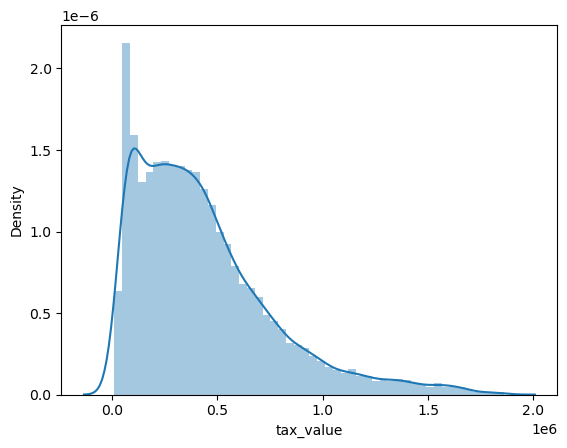

In [32]:
sns.distplot(explore_train.tax_value)
plt.show()

In [33]:
t, p = stats.ttest_1samp(three_plus, μ) #1samp, 1 tailed, not independent
t, p

(7.432120072740061, 1.138551207861459e-13)

#### Takeaways:
- $H_{a}$ is accepted, meaning that homes with 3+ bedrooms have greater tax value than average homes

# Modeling

### Auto-feature selection
- using both rfe and kbest

In [34]:
# Selecting the one best feature using RFE
rfe_best = md.rfe_features(3)
rfe_best

,Feat_names,F_rank
0,bedrooms,1
1,bathrooms,1
2,area,1


In [35]:
# Selecting best feature using kbest to cross check with rfe
k_best = md.kbest_features(3, show_scores = True)
k_best

,Feat_names,F_Scores
2,area,6867.297410
1,bathrooms,4542.842698
0,bedrooms,1160.104658


## Model 1: OLS

In [36]:
ols_train, ols_validate, ols_test, ols_error, ols_sig = md.lin_reg(['area','bathrooms', 'bedrooms'], 'tax_value', model_type=LinearRegression(normalize=True))

In [37]:
ols_validate.head()

,area_validate,bathrooms_validate,bedrooms_validate,yhat_validate,tax_value_validate,yhat_baseline,yhat_median,residuals,residual^2,residual_baseline,residual_baseline^2
26487,1.580054,0.907381,0.830351,720282.138038,709000.0,434266.036734,388164.597856,11282.138038,1.272866e+08,-274733.963266,7.547875e+10
9551,-0.576754,-0.842220,-0.305196,310716.420052,484000.0,434266.036734,388164.597856,-173283.579948,3.002720e+10,-49733.963266,2.473467e+09
27960,-0.310052,-0.259019,-1.440744,445373.638730,405196.0,434266.036734,388164.597856,40177.638730,1.614243e+09,29070.036734,8.450670e+08
4037,1.272123,0.907381,0.830351,662306.546776,774974.0,434266.036734,388164.597856,-112667.453224,1.269396e+10,-340707.963266,1.160819e+11
11883,-0.257227,-0.259019,-0.305196,392859.705858,92894.0,434266.036734,388164.597856,299965.705858,8.997942e+10,341372.036734,1.165349e+11


In [38]:
ols_train.head()

,area_train,bathrooms_train,bedrooms_train,yhat_train,tax_value_train,yhat_baseline,yhat_median,residuals,residual^2,residual_baseline,residual_baseline^2
4406,2.164995,0.907381,3.101447,705492.431079,616142.0,434266.036734,388164.597856,89350.431079,7.983500e+09,-181875.963266,3.307887e+10
6788,0.365078,-0.259019,0.830351,447564.230467,87354.0,434266.036734,388164.597856,360210.230467,1.297514e+11,346912.036734,1.203480e+11
18633,1.661225,0.907381,-0.305196,798023.943259,263921.0,434266.036734,388164.597856,534102.943259,2.852660e+11,170345.036734,2.901743e+10
182,1.384215,0.907381,3.101447,558491.559510,425115.0,434266.036734,388164.597856,133376.559510,1.778931e+10,9151.036734,8.374147e+07
24485,1.290161,0.324181,-0.305196,706177.629626,1250000.0,434266.036734,388164.597856,-543822.370374,2.957428e+11,-815733.963266,6.654219e+11


In [39]:
ols_test.head()

,area_test,bathrooms_test,bedrooms_test,yhat_test,tax_value_test,yhat_baseline,yhat_median,residuals,residual^2,residual_baseline,residual_baseline^2
2535,0.036532,0.907381,-0.305196,492135.991034,206000.0,434266.036734,388164.597856,286135.991034,8.187381e+10,228266.036734,5.210538e+10
4330,-0.869225,-0.259019,-0.305196,277636.250420,353676.0,434266.036734,388164.597856,-76039.749580,5.782044e+09,80590.036734,6.494754e+09
27113,0.814735,-0.259019,0.830351,532223.148252,123267.0,434266.036734,388164.597856,408956.148252,1.672451e+11,310999.036734,9.672040e+10
16764,-0.570312,-0.259019,-0.305196,333913.811813,422078.0,434266.036734,388164.597856,-88164.188187,7.772924e+09,12188.036734,1.485482e+08
5182,0.236236,-0.259019,-0.305196,485766.197295,163284.0,434266.036734,388164.597856,322482.197295,1.039948e+11,270982.036734,7.343126e+10


In [40]:
ols_error

,metric,model_error,error_delta
0,SSE_train,1.094567e+15,-5.397650e+14
1,MSE_train,7.270936e+10,-3.585526e+10
2,RMSE_train,2.696467e+05,-5.984472e+04
3,SSE_validate,4.611694e+14,-1.173162e+15
4,MSE_validate,7.146589e+10,-3.709873e+10
5,RMSE_validate,2.673311e+05,-6.216040e+04
6,SSE_test,3.925984e+14,-1.241733e+15
7,MSE_test,7.301440e+10,-3.555022e+10
8,RMSE_test,2.702118e+05,-5.927968e+04
0,SSE_baseline,1.634332e+15,NaN


In [41]:
ols_sig

,metric,model_significance
0,ESS_train,5.397650e+14
1,R2_train,3.302665e-01
2,TSS,1.634332e+15
3,ESS_validate,2.262548e+14
4,R2_validate,3.330302e-01
5,ESS_test,1.887027e+14
6,R2_test,3.299127e-01
0,ESS_baseline,0.000000e+00
1,TSS_baseline,1.634332e+15
2,R^2_baseline,0.000000e+00


## Model 2: LARS + LASSO

In [42]:
llso_train, llso_validate, llso_test, llso_error, llso_sig = md.lin_reg(['area','bathrooms', 'bedrooms'], 'tax_value', model_type=LassoLars(alpha=2.0, normalize = True))

In [43]:
llso_train.head()

,area_train,bathrooms_train,bedrooms_train,yhat_train,tax_value_train,yhat_baseline,yhat_median,residuals,residual^2,residual_baseline,residual_baseline^2
4406,2.164995,0.907381,3.101447,706549.541261,616142.0,434266.036734,388236.932121,90407.541261,8.173524e+09,-181875.963266,3.307887e+10
6788,0.365078,-0.259019,0.830351,448118.694583,87354.0,434266.036734,388236.932121,360764.694583,1.301512e+11,346912.036734,1.203480e+11
18633,1.661225,0.907381,-0.305196,796786.347294,263921.0,434266.036734,388236.932121,532865.347294,2.839455e+11,170345.036734,2.901743e+10
182,1.384215,0.907381,3.101447,559869.228603,425115.0,434266.036734,388236.932121,134754.228603,1.815870e+10,9151.036734,8.374147e+07
24485,1.290161,0.324181,-0.305196,705305.411487,1250000.0,434266.036734,388236.932121,-544694.588513,2.966922e+11,-815733.963266,6.654219e+11


In [44]:
llso_validate.head()

,area_validate,bathrooms_validate,bedrooms_validate,yhat_validate,tax_value_validate,yhat_baseline,yhat_median,residuals,residual^2,residual_baseline,residual_baseline^2
26487,1.580054,0.907381,0.830351,719911.712642,709000.0,434266.036734,388236.932121,10911.712642,1.190655e+08,-274733.963266,7.547875e+10
9551,-0.576754,-0.842220,-0.305196,311036.752827,484000.0,434266.036734,388236.932121,-172963.247173,2.991628e+10,-49733.963266,2.473467e+09
27960,-0.310052,-0.259019,-1.440744,444537.595526,405196.0,434266.036734,388236.932121,39341.595526,1.547761e+09,29070.036734,8.450670e+08
4037,1.272123,0.907381,0.830351,662062.546429,774974.0,434266.036734,388236.932121,-112911.453571,1.274900e+10,-340707.963266,1.160819e+11
11883,-0.257227,-0.259019,-0.305196,392835.819812,92894.0,434266.036734,388236.932121,299941.819812,8.996510e+10,341372.036734,1.165349e+11


In [45]:
llso_test.head()

,area_test,bathrooms_test,bedrooms_test,yhat_test,tax_value_test,yhat_baseline,yhat_median,residuals,residual^2,residual_baseline,residual_baseline^2
2535,0.036532,0.907381,-0.305196,491565.432672,206000.0,434266.036734,388236.932121,285565.432672,8.154762e+10,228266.036734,5.210538e+10
4330,-0.869225,-0.259019,-0.305196,277863.627547,353676.0,434266.036734,388236.932121,-75812.372453,5.747516e+09,80590.036734,6.494754e+09
27113,0.814735,-0.259019,0.830351,532593.000058,123267.0,434266.036734,388236.932121,409326.000058,1.675478e+11,310999.036734,9.672040e+10
16764,-0.570312,-0.259019,-0.305196,334018.466716,422078.0,434266.036734,388236.932121,-88059.533284,7.754481e+09,12188.036734,1.485482e+08
5182,0.236236,-0.259019,-0.305196,485539.713785,163284.0,434266.036734,388236.932121,322255.713785,1.038487e+11,270982.036734,7.343126e+10


In [46]:
llso_error

,metric,model_error,error_delta
0,SSE_train,1.094572e+15,-5.397594e+14
1,MSE_train,7.270973e+10,-3.585488e+10
2,RMSE_train,2.696474e+05,-5.984403e+04
3,SSE_validate,4.611450e+14,-1.173187e+15
4,MSE_validate,7.146211e+10,-3.710251e+10
5,RMSE_validate,2.673240e+05,-6.216749e+04
6,SSE_test,3.925839e+14,-1.241748e+15
7,MSE_test,7.301170e+10,-3.555292e+10
8,RMSE_test,2.702068e+05,-5.928469e+04
0,SSE_baseline,1.634332e+15,NaN


In [47]:
llso_sig

,metric,model_significance
0,ESS_train,5.376947e+14
1,R2_train,3.289997e-01
2,TSS,1.634332e+15
3,ESS_validate,2.253850e+14
4,R2_validate,3.317498e-01
5,ESS_test,1.879584e+14
6,R2_test,3.286113e-01
0,ESS_baseline,0.000000e+00
1,TSS_baseline,1.634332e+15
2,R^2_baseline,0.000000e+00


## Model 3: GLM

In [48]:
twee_train, twee_validate, twee_test, twee_error, twee_sig = md.lin_reg(['area','bathrooms', 'bedrooms'], 'tax_value', model_type=TweedieRegressor(power=0, alpha=1.0))

In [49]:
twee_train.head()

,area_train,bathrooms_train,bedrooms_train,yhat_train,tax_value_train,yhat_baseline,yhat_median,residuals,residual^2,residual_baseline,residual_baseline^2
4406,2.164995,0.907381,3.101447,650789.355563,616142.0,434266.036734,408181.25078,34647.355563,1.200439e+09,-181875.963266,3.307887e+10
6788,0.365078,-0.259019,0.830351,452940.770574,87354.0,434266.036734,408181.25078,365586.770574,1.336537e+11,346912.036734,1.203480e+11
18633,1.661225,0.907381,-0.305196,592601.705799,263921.0,434266.036734,408181.25078,328680.705799,1.080310e+11,170345.036734,2.901743e+10
182,1.384215,0.907381,3.101447,596004.697973,425115.0,434266.036734,408181.25078,170889.697973,2.920329e+10,9151.036734,8.374147e+07
24485,1.290161,0.324181,-0.305196,538401.406958,1250000.0,434266.036734,408181.25078,-711598.593042,5.063726e+11,-815733.963266,6.654219e+11


In [50]:
twee_validate.head()

,area_validate,bathrooms_validate,bedrooms_validate,yhat_validate,tax_value_validate,yhat_baseline,yhat_median,residuals,residual^2,residual_baseline,residual_baseline^2
26487,1.580054,0.907381,0.830351,594519.535477,709000.0,434266.036734,408181.25078,-114480.464523,1.310578e+10,-274733.963266,7.547875e+10
9551,-0.576754,-0.842220,-0.305196,351078.357004,484000.0,434266.036734,408181.25078,-132921.642996,1.766816e+10,-49733.963266,2.473467e+09
27960,-0.310052,-0.259019,-1.440744,390342.689710,405196.0,434266.036734,408181.25078,-14853.310290,2.206208e+08,29070.036734,8.450670e+08
4037,1.272123,0.907381,0.830351,572913.045108,774974.0,434266.036734,408181.25078,-202060.954892,4.082863e+10,-340707.963266,1.160819e+11
11883,-0.257227,-0.259019,-0.305196,401662.506830,92894.0,434266.036734,408181.25078,308768.506830,9.533799e+10,341372.036734,1.165349e+11


In [51]:
twee_test.head()

,area_test,bathrooms_test,bedrooms_test,yhat_test,tax_value_test,yhat_baseline,yhat_median,residuals,residual^2,residual_baseline,residual_baseline^2
2535,0.036532,0.907381,-0.305196,478602.608075,206000.0,434266.036734,408181.25078,272602.608075,7.431218e+10,228266.036734,5.210538e+10
4330,-0.869225,-0.259019,-0.305196,358720.737267,353676.0,434266.036734,408181.25078,5044.737267,2.544937e+07,80590.036734,6.494754e+09
27113,0.814735,-0.259019,0.830351,484491.670737,123267.0,434266.036734,408181.25078,361224.670737,1.304833e+11,310999.036734,9.672040e+10
16764,-0.570312,-0.259019,-0.305196,379694.401558,422078.0,434266.036734,408181.25078,-42383.598442,1.796369e+09,12188.036734,1.485482e+08
5182,0.236236,-0.259019,-0.305196,436287.133656,163284.0,434266.036734,408181.25078,273003.133656,7.453071e+10,270982.036734,7.343126e+10


In [52]:
twee_error

,metric,model_error,error_delta
0,SSE_train,1.205391e+15,-4.289405e+14
1,MSE_train,8.007116e+10,-2.849346e+10
2,RMSE_train,2.829685e+05,-4.652298e+04
3,SSE_validate,5.029801e+14,-1.131352e+15
4,MSE_validate,7.794516e+10,-3.061946e+10
5,RMSE_validate,2.791866e+05,-5.030484e+04
6,SSE_test,4.272420e+14,-1.207090e+15
7,MSE_test,7.945731e+10,-2.910731e+10
8,RMSE_test,2.818817e+05,-4.760972e+04
0,SSE_baseline,1.634332e+15,NaN


In [53]:
twee_sig

,metric,model_significance
0,ESS_train,2.091391e+14
1,R2_train,1.279661e-01
2,TSS,1.634332e+15
3,ESS_validate,8.794220e+13
4,R2_validate,1.294443e-01
5,ESS_test,7.266662e+13
6,R2_test,1.270445e-01
0,ESS_baseline,0.000000e+00
1,TSS_baseline,1.634332e+15
2,R^2_baseline,0.000000e+00


In [54]:
rmse_train_ols = ols_error[ols_error.metric == 'RMSE_train'].model_error.values
rmse_validate_ols = ols_error[ols_error.metric == 'RMSE_validate'].model_error.values
rmse_test_ols = ols_error[ols_error.metric == 'RMSE_test'].model_error.values
r_2_train = ols_sig[ols_sig.metric == 'R2_train'].model_significance.values
r_2_validate = ols_sig[ols_sig.metric == 'R2_validate'].model_significance.values
r_2_test = ols_sig[ols_sig.metric == 'R2_test'].model_significance.values

print("RMSE using OLS\nTrain/In-Sample: ", rmse_train_ols.round(2), 
     "\nValidate/Out-of-Sample: ", rmse_validate_ols,
      "\nTest/Out-of-Sample: ", rmse_test_ols.round(2), 
     "\nR^2 Train: ", r_2_train.round(3), 
     "\nR^2 Validate: ", r_2_validate.round(3), 
     "\nR^2 Test: ", r_2_test.round(3))

RMSE using OLS
Train/In-Sample:  [269646.74] 
Validate/Out-of-Sample:  [267331.05241838] 
Test/Out-of-Sample:  [270211.77] 
R^2 Train:  [0.33] 
R^2 Validate:  [0.333] 
R^2 Test:  [0.33]


In [55]:
rmse_train_llso = llso_error[llso_error.metric == 'RMSE_train'].model_error.values
rmse_validate_llso = llso_error[llso_error.metric == 'RMSE_validate'].model_error.values
rmse_test_llso = llso_error[llso_error.metric == 'RMSE_test'].model_error.values
r_2_train = llso_sig[llso_sig.metric == 'R2_train'].model_significance.values
r_2_validate = llso_sig[llso_sig.metric == 'R2_validate'].model_significance.values
r_2_test = llso_sig[llso_sig.metric == 'R2_test'].model_significance.values
print("RMSE using Lars + Lasso\nTrain/In-Sample: ", rmse_train_llso.round(2), 
     "\nValidate/Out-of-Sample: ", rmse_validate_llso,
      "\nTest/Out-of-Sample: ", rmse_test_llso.round(2), 
     "\nR^2 Train: ", r_2_train.round(3), 
     "\nR^2 Validate: ", r_2_validate.round(3), 
     "\nR^2 Test: ", r_2_test.round(3))

RMSE using Lars + Lasso
Train/In-Sample:  [269647.43] 
Validate/Out-of-Sample:  [267323.97019184] 
Test/Out-of-Sample:  [270206.76] 
R^2 Train:  [0.329] 
R^2 Validate:  [0.332] 
R^2 Test:  [0.329]


In [56]:
rmse_train_glm = twee_error[twee_error.metric == 'RMSE_train'].model_error.values
rmse_validate_glm = twee_error[twee_error.metric == 'RMSE_validate'].model_error.values
rmse_test_glm = twee_error[twee_error.metric == 'RMSE_test'].model_error.values
r_2_train = twee_sig[twee_sig.metric == 'R2_train'].model_significance.values
r_2_validate = twee_sig[twee_sig.metric == 'R2_validate'].model_significance.values
r_2_test = twee_sig[twee_sig.metric == 'R2_test'].model_significance.values
print("RMSE using Tweedie Regressor\nTrain/In-Sample: ", rmse_train_glm.round(2), 
     "\nValidate/Out-of-Sample: ", rmse_validate_glm.round(2),
      "\nTest/Out-of-Sample: ", rmse_test_glm.round(2), 
     "\nR^2 Train: ", r_2_train.round(3), 
     "\nR^2 Validate: ", r_2_validate.round(3), 
     "\nR^2 Test: ", r_2_test.round(3))

RMSE using Tweedie Regressor
Train/In-Sample:  [282968.48] 
Validate/Out-of-Sample:  [279186.61] 
Test/Out-of-Sample:  [281881.73] 
R^2 Train:  [0.128] 
R^2 Validate:  [0.129] 
R^2 Test:  [0.127]


In [57]:
md.better_than_baseline(ols_test.tax_value_test, ols_test.yhat_test, ols_sig[ols_sig.metric == 'R2_test'].model_significance.values, ols_sig[ols_sig.metric == 'R^2_baseline'].model_significance.values)

'RMSE better than baseline\nR^2 better than baseline'

## Plotting Actual vs Predicted

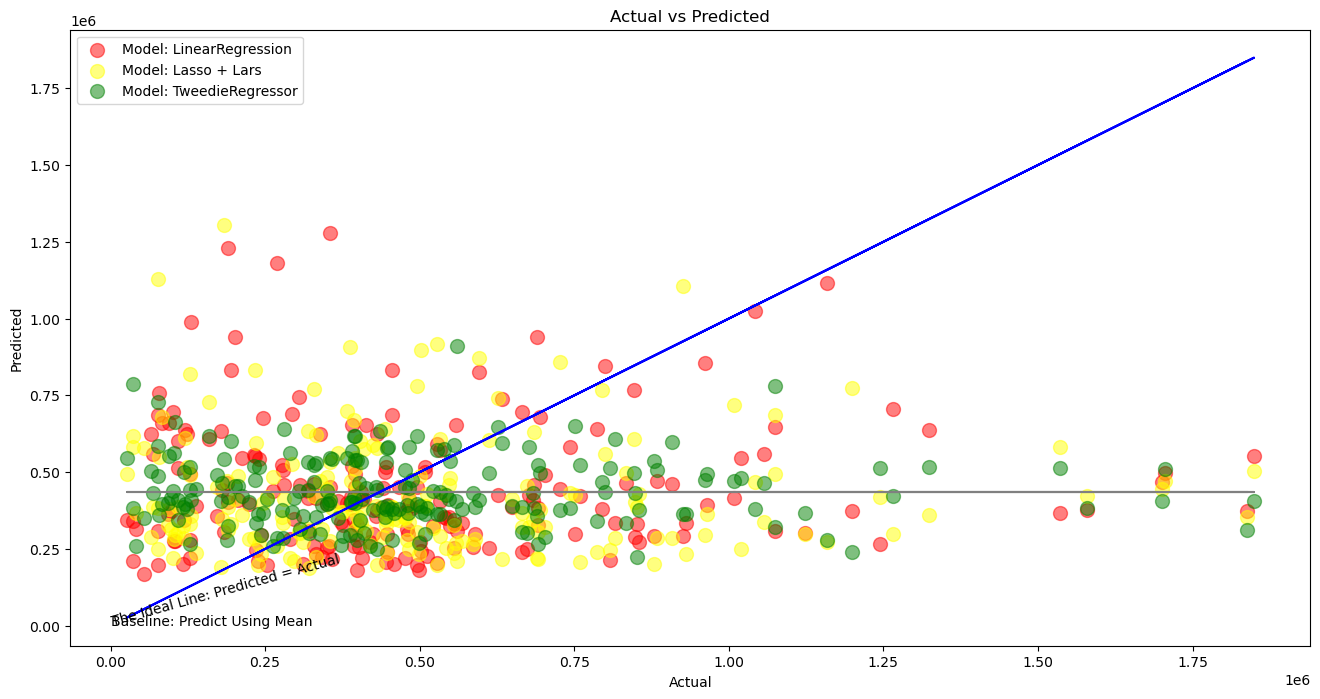

In [58]:
md.plot_actual_vs_pred(y_validate.sample(200), ols_validate.yhat_baseline.sample(200), ols_validate.yhat_validate.sample(200), llso_validate.yhat_validate.sample(200), twee_validate.yhat_validate.sample(200))

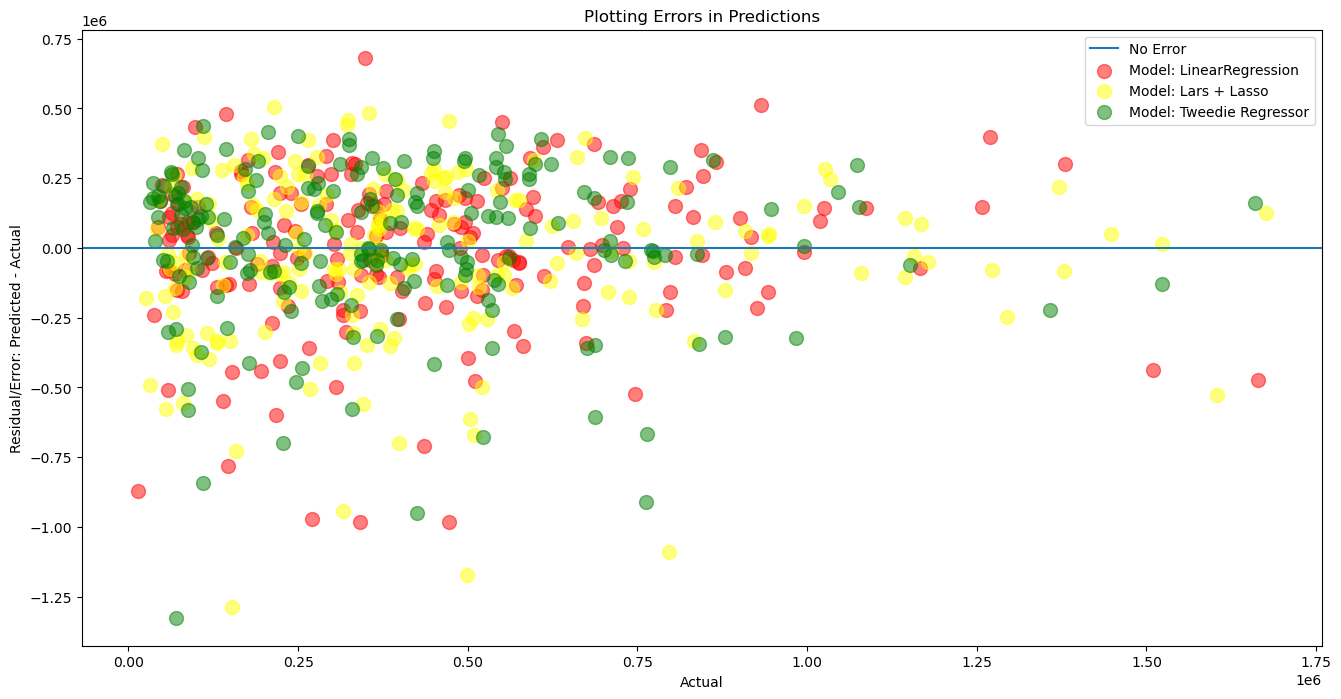

In [59]:
md.plot_errors(y_validate, ols_validate.yhat_baseline, ols_validate.yhat_validate, llso_validate.yhat_validate, twee_validate.yhat_validate)

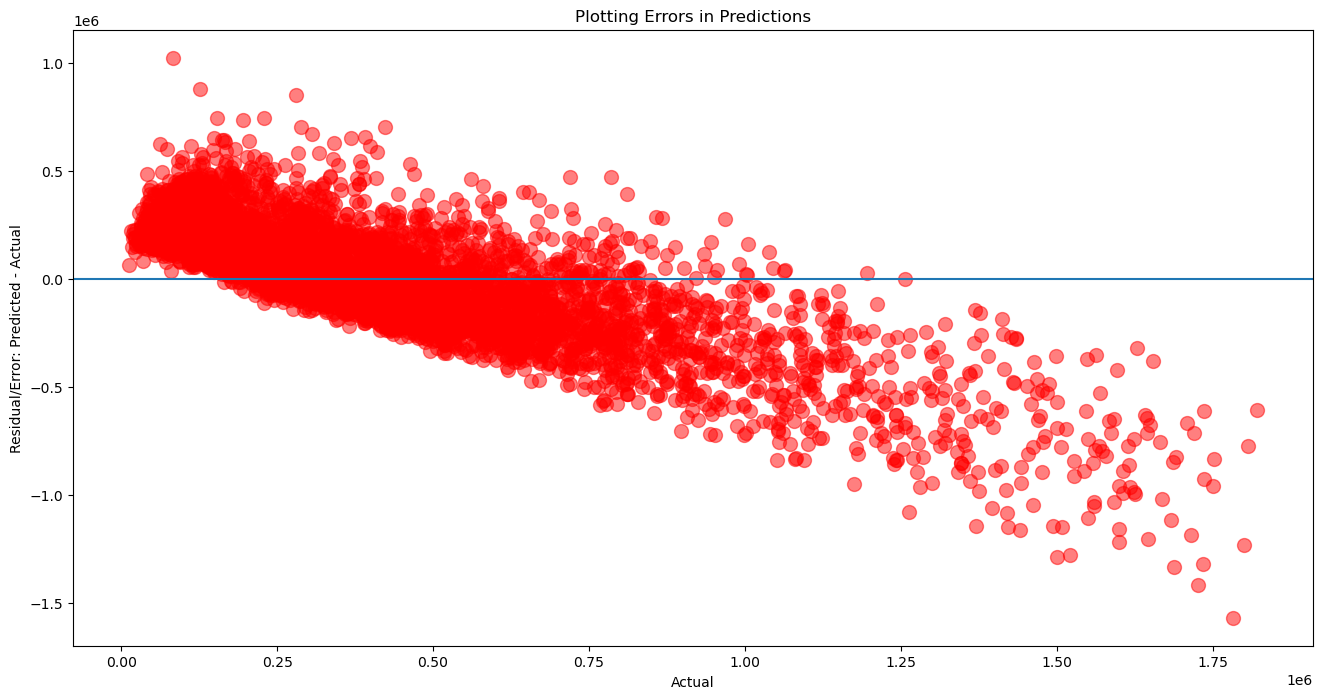

In [60]:
plt.figure(figsize=(16,8))
plt.axhline(label="No Error")
plt.scatter(y_test, ols_test.yhat_test - y_test, 
        alpha=.5, color="red", s=100, label="Model: LinearRegression")
plt.xlabel("Actual")
plt.ylabel("Residual/Error: Predicted - Actual")
plt.title("Plotting Errors in Predictions")
plt.show()

# Takeaways/Conclusion:
- OLS model outpreformed other models by a slim margin
- I would like to further examine the relationship between features and their relation to churn. Additionally, I would like to pull additional features from the Zillow dataset and delve deeper into auto-feature selection. I would also like to further play with the hyperparameters of my models. 